In [16]:
import pandas as pd
import json
from evaluation_utils import read_processed_shards, get_best_configuration_per_model
from constants import *
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter
from scipy.stats import f_oneway
from tqdm import tqdm
from collections import defaultdict
import scipy

In [4]:
PROCESSED_DIR = f'/home/data_shares/scara/graphworld/results/mode-2-3-marg/processed'
df = read_processed_shards(PROCESSED_DIR)

1.ndjson
concatenating


In [24]:
METRIC = 'test_rocauc_ovr'

In [56]:
# Function for 1D lineplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

def bucket_response_surface1d(results_df, xvar, metric='test_accuracy',
                              group=False, ngrid=25, custom_range=None):
  # BAD_VALS = [np.nan, np.inf, -np.inf]
  # results_df_inner = results_df[~results_df.isin(BAD_VALS).any(1)]
  results_df_inner = results_df.copy(deep=True)
  if custom_range is None:
    min_xvar = np.min(results_df_inner[xvar])
    max_xvar = np.max(results_df_inner[xvar])
  else:
    min_xvar = custom_range[0]
    max_xvar = custom_range[1]
  xrange = np.linspace(min_xvar, max_xvar, ngrid)
  def convert_value(z, range):
    return range[np.argmin(np.abs(range - z))]
  results_df_inner[xvar] = results_df_inner[xvar].apply(convert_value,
                                                        range=xrange)
  if group:
    return results_df_inner.groupby([xvar])[[xvar, metric]].mean()
  else:
    return results_df_inner

def plot_response_surface1d(param, metric, results_df, models, reverse_x=False, ci=99, ax=None):
  bucketed_dfs = []
  index_pos = 0
  grouped_index_pos = 0
  grouped_bucketed_dfs = []
  for model in models:
    model_metric = '%s_%s' % (model, metric)
    if model_metric not in results_df.columns:
      continue

    # Get and store ungrouped bucketed df
    bucketed_df = bucket_response_surface1d(results_df, param,
                                            metric=model_metric,
                                            group=False)
    bucketed_df = bucketed_df.rename(columns={model_metric: metric})
    bucketed_df['model'] = model
    new_index = list(range(index_pos, index_pos + bucketed_df.shape[0]))
    bucketed_df.index = new_index
    bucketed_dfs.append(bucketed_df)
    index_pos += bucketed_df.shape[0]

    # Get and store grouped bucketed df
    grouped_bucketed_df = bucket_response_surface1d(results_df, param,
                                                    metric=model_metric,
                                                    group=True)
    grouped_bucketed_df = grouped_bucketed_df.rename(
        columns={model_metric: metric})
    grouped_bucketed_df['model'] = model
    grouped_new_index = list(range(
        grouped_index_pos, grouped_index_pos + grouped_bucketed_df.shape[0]))
    grouped_bucketed_df.index = grouped_new_index
    grouped_bucketed_dfs.append(grouped_bucketed_df)
    grouped_index_pos += grouped_bucketed_df.shape[0]

    
    
  plot_df = pd.concat(bucketed_dfs, axis=0)

  range_x = (np.min(results_df[param]), np.max(results_df[param]))
  if reverse_x:
    range_x = (range_x[1], range_x[0])

  sns.lineplot(data=plot_df, x=param, y=metric, hue="model", errorbar=('ci', ci), ax=ax)

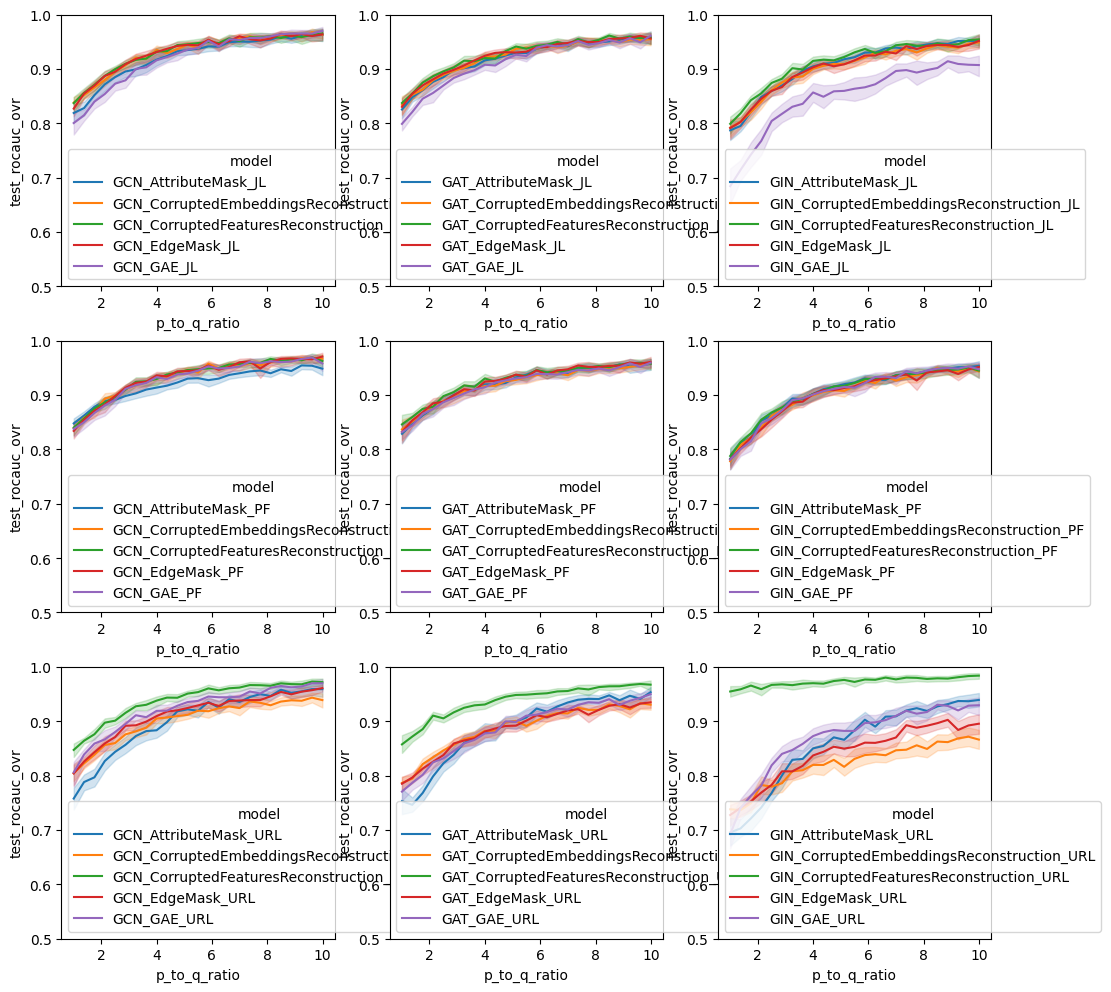

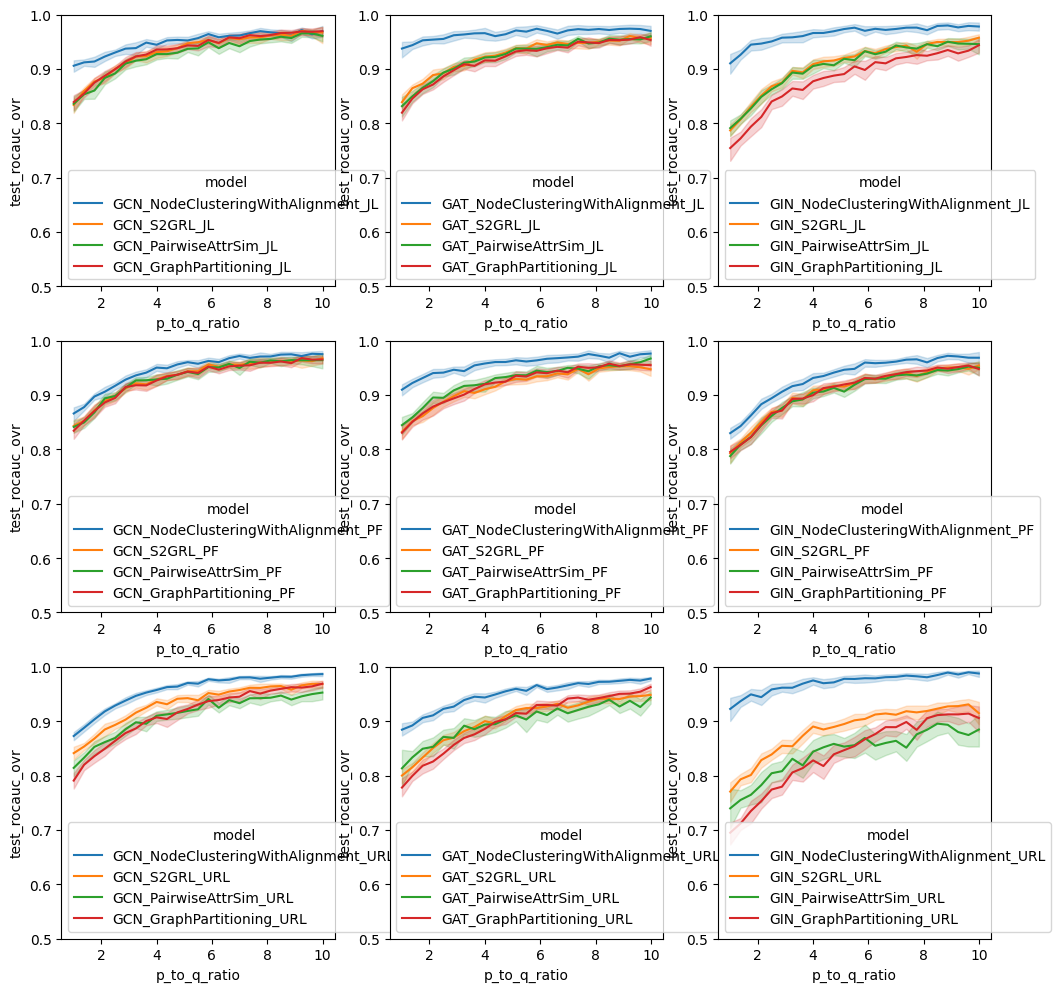

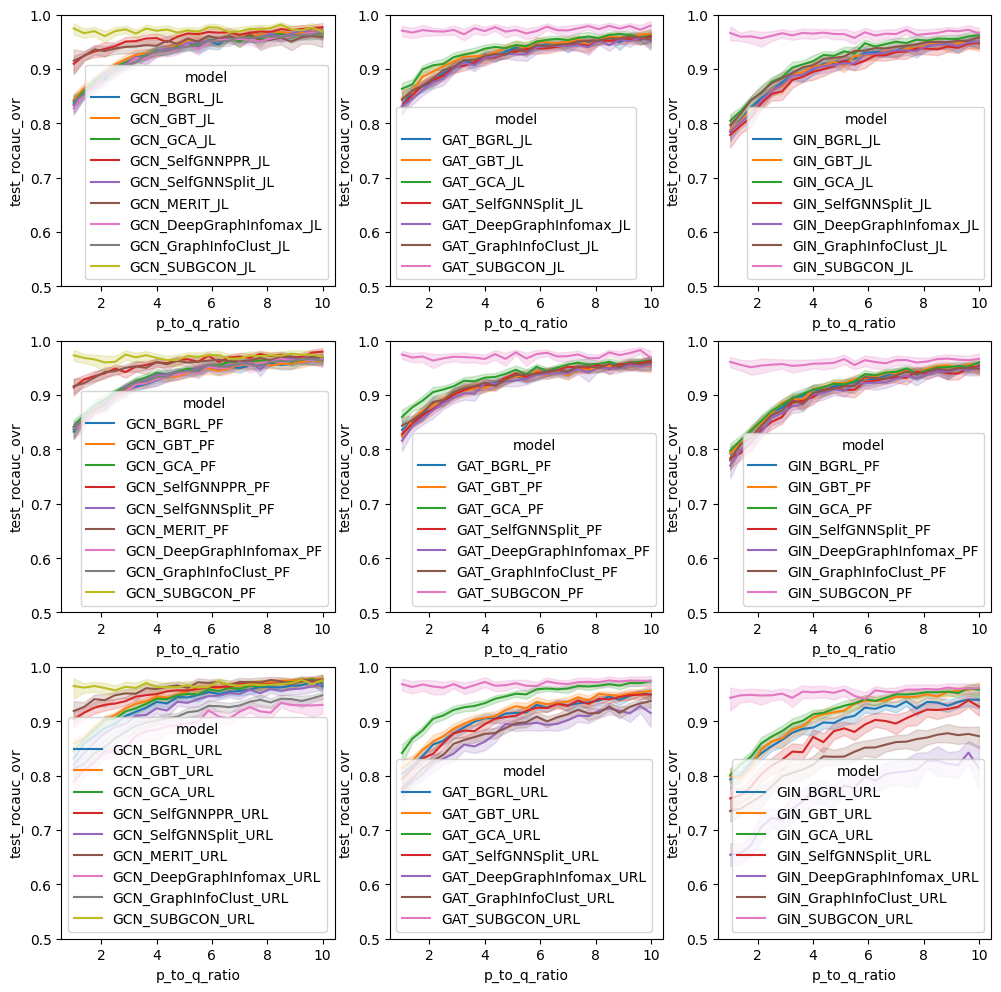

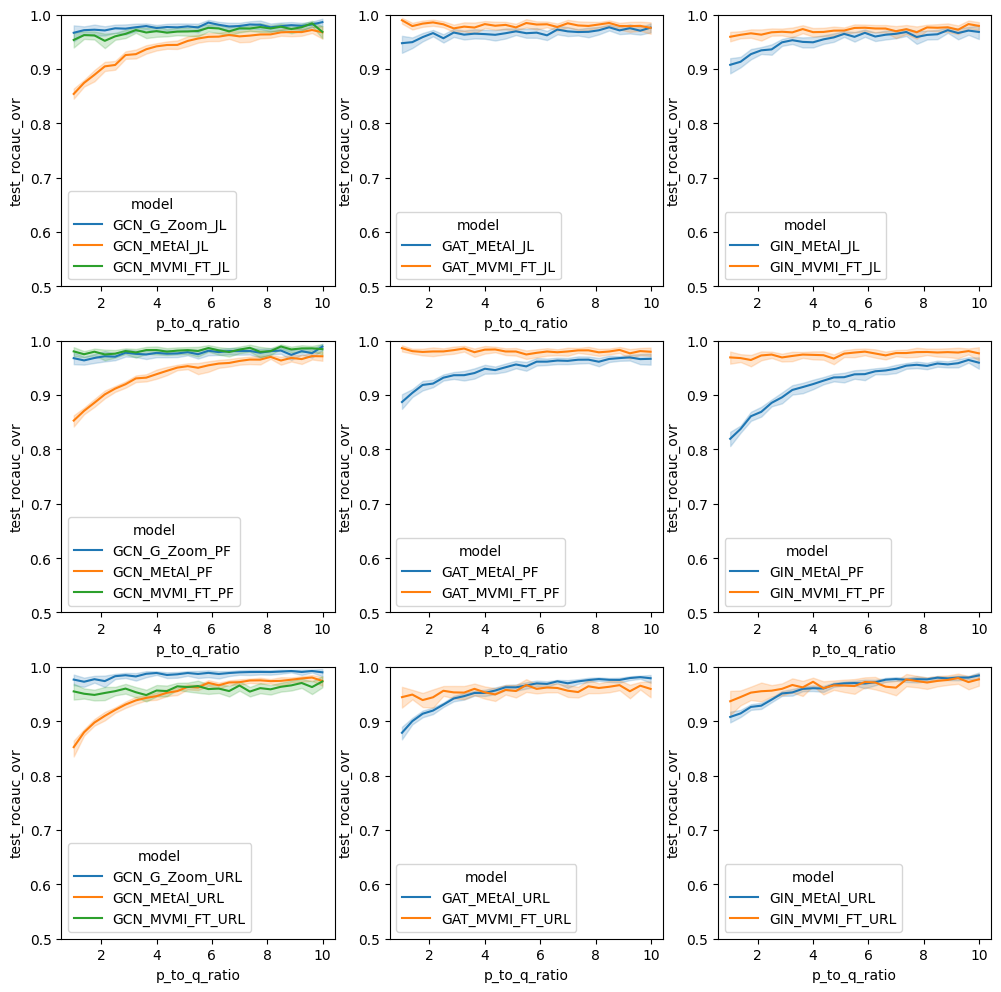

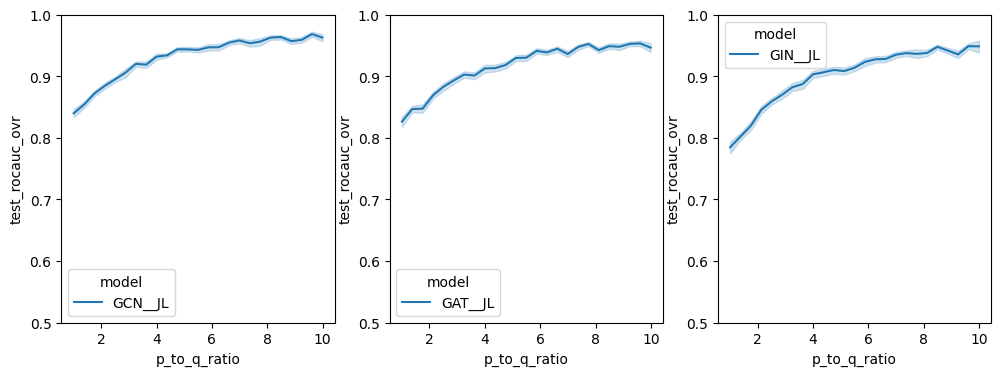

In [58]:
for category in [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL]:
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
    for ts, axss in zip(['JL', 'PF', 'URL'], axs):
        for encoder, ax in zip(['GCN', 'GAT', 'GIN'], axss):
            models = []
            for model in category:
                models.append(f'{encoder}_{model}_{ts}')
            ax.set_ylim(0.5, 1.0)
            plot_response_surface1d('p_to_q_ratio', METRIC, df, models, ax=ax)
    plt.show()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
for encoder, ax in zip(['GCN', 'GAT', 'GIN'], axs):
    models = []
    for model in ["","",""]:
        models.append(f'{encoder}_{model}_JL')
    ax.set_ylim(0.5, 1.0)
    plot_response_surface1d('p_to_q_ratio', METRIC, df, models, ax=ax)
plt.show()

    